In [3]:
import sqlite3
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Row
from os import path
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import *
import seaborn as sns
import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import findspark
findspark.init()

In [4]:
spark = SparkSession.builder.enableHiveSupport().appName('YelpRecommenderAnalysis').getOrCreate()
sc = spark.sparkContext
sc.defaultParallelism

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/03/05 21:02:52 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/03/05 21:02:52 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/03/05 21:02:53 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/03/05 21:02:53 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


2

In [5]:
df_business = spark.read.json("gs://msca-bdp-student-gcs/Group9_Final_Project_Data/yelp_academic_dataset_business.json")
df_checkin = spark.read.json("gs://msca-bdp-student-gcs/Group9_Final_Project_Data/yelp_academic_dataset_checkin.json")
df_review = spark.read.json("gs://msca-bdp-student-gcs/Group9_Final_Project_Data/yelp_academic_dataset_review.json")
df_tip = spark.read.json("gs://msca-bdp-student-gcs/Group9_Final_Project_Data/yelp_academic_dataset_tip.json")
df_user = spark.read.json("gs://msca-bdp-student-gcs/Group9_Final_Project_Data/yelp_academic_dataset_user.json")

23/03/05 21:03:53 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [6]:
df_business = df_business.withColumnRenamed('stars', 'business_stars')
df_review = df_review.withColumnRenamed('stars', 'review_stars')
df_review = df_review.withColumnRenamed('business_id', 'review_business_id')
columns_to_drop = ['address','postal_code','latitude','longitude','review_count']
df_business = df_business.drop(*columns_to_drop)
df_business = df_business.filter(df_business.categories.contains('Restaurants'))
df_business = df_business.withColumnRenamed('name', 'business_name')

In [8]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer,StringIndexer,CountVectorizer
import pyspark.mllib.classification
from pyspark.sql.functions import udf
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml import Pipeline
import string
import re

In [9]:
business_restaurant = df_business.select('business_id', 'categories', 'state', 'business_name')


# Get all useful reviews, i.e. a review with at least one useful vote and 
# here we are excluding all neutral reviews as well
review_useful = df_review.select('review_business_id', 'review_id', 'review_stars', 
                              'text', 'useful', 'user_id') \
                      .where("useful >= 1 and stars != 3")


# Join the two dataframes above to get all useful reviews for restaurant businesses
restaurant_useful_review = business_restaurant.join(review_useful, 
                                                    [business_restaurant.business_id == review_useful.review_business_id], 
                                                    how = 'inner')

In [39]:
restaurant_useful_review.show(5)

+--------------------+--------------------+-----+---------------+--------------------+--------------------+------------+--------------------+------+--------------------+
|         business_id|          categories|state|  business_name|  review_business_id|           review_id|review_stars|                text|useful|             user_id|
+--------------------+--------------------+-----+---------------+--------------------+--------------------+------------+--------------------+------+--------------------+
|kxX2SOes4o-D3ZQBk...|Halal, Pakistani,...|   PA|          Zaika|kxX2SOes4o-D3ZQBk...|AqPFMleE6RsU23_au...|         5.0|Wow!  Yummy, diff...|     1|_7bHUi9Uuf5__HHc_...|
|e4Vwtrqf-wpJfwesg...|Sandwiches, Beer,...|   LA|           Melt|e4Vwtrqf-wpJfwesg...|Sx8TMOWLNuJBWer-0...|         4.0|Cute interior and...|     1|bcjbaE6dDog4jkNY9...|
|04UD14gamNjLY0IDY...|Mediterranean, Re...|   PA|       Dmitri's|04UD14gamNjLY0IDY...|JrIxlS1TzJ-iCu79u...|         1.0|I am a long term ...|     1|eU

In [10]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

In [11]:
df_als = restaurant_useful_review.select('user_id','business_id','business_name','review_stars')

In [12]:
from pyspark.ml.feature import StringIndexer

user_id_indexer = StringIndexer(inputCol="user_id", outputCol="user_id_int") 
user_id_indexed = user_id_indexer.fit(df_als).transform(df_als) 
user_id_indexed.show()

23/03/05 21:06:40 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 25.9 MiB


+--------------------+--------------------+--------------------+------------+-----------+
|             user_id|         business_id|       business_name|review_stars|user_id_int|
+--------------------+--------------------+--------------------+------------+-----------+
|_7bHUi9Uuf5__HHc_...|kxX2SOes4o-D3ZQBk...|               Zaika|         5.0|   440047.0|
|bcjbaE6dDog4jkNY9...|e4Vwtrqf-wpJfwesg...|                Melt|         4.0|     8524.0|
|eUta8W_HdHMXPzLBB...|04UD14gamNjLY0IDY...|            Dmitri's|         1.0|   473296.0|
|yfFzsLmaWF2d4Sr0U...|LHSTtnW3YHCeUkRDG...|     Fries Rebellion|         5.0|   598073.0|
|j2wlzrntrbKwyOcOi...|rBdG_23USc7DletfZ...|                Olio|         4.0|     4689.0|
|RreNy--tOmXMl1en0...|cPepkJeRMtHapc_b2...|Naked Tchopstix E...|         4.0|     3421.0|
|mNsVyC9tQVYtzLOCb...|MWmXGQ98KbRo3vsS5...|Anthony's at Paxo...|         5.0|    59244.0|
|QzCEzH3R7Z6erOGLr...|0pMj5xUAecW9o1P35...|                Wawa|         5.0|   160132.0|
|EZjT2qJN0

In [17]:
business_id_indexer = StringIndexer(inputCol="business_id", outputCol="business_id_int") 
df_als = business_id_indexer.fit(user_id_indexed).transform(user_id_indexed) 
df_als.show()

23/03/05 21:11:46 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 28.5 MiB


+--------------------+--------------------+--------------------+------------+-----------+---------------+
|             user_id|         business_id|       business_name|review_stars|user_id_int|business_id_int|
+--------------------+--------------------+--------------------+------------+-----------+---------------+
|_7bHUi9Uuf5__HHc_...|kxX2SOes4o-D3ZQBk...|               Zaika|         5.0|   440047.0|         3634.0|
|bcjbaE6dDog4jkNY9...|e4Vwtrqf-wpJfwesg...|                Melt|         4.0|     8524.0|        22766.0|
|eUta8W_HdHMXPzLBB...|04UD14gamNjLY0IDY...|            Dmitri's|         1.0|   473296.0|         2474.0|
|yfFzsLmaWF2d4Sr0U...|LHSTtnW3YHCeUkRDG...|     Fries Rebellion|         5.0|   598073.0|         9010.0|
|j2wlzrntrbKwyOcOi...|rBdG_23USc7DletfZ...|                Olio|         4.0|     4689.0|         2144.0|
|RreNy--tOmXMl1en0...|cPepkJeRMtHapc_b2...|Naked Tchopstix E...|         4.0|     3421.0|        21160.0|
|mNsVyC9tQVYtzLOCb...|MWmXGQ98KbRo3vsS5...|Ant

In [19]:
from pyspark.sql.types import IntegerType
df_als = df_als.withColumn("user_id_int", df_als["user_id_int"].cast(IntegerType()))
df_als = df_als.withColumn("business_id_int", df_als["business_id_int"].cast(IntegerType()))

In [20]:
df_als = df_als.drop('business_id','user_id','business_name')
#df_als = df_als.sample(fraction=0.1)

In [21]:
train_df, test_df = df_als.randomSplit([0.7,0.3],seed=1)
als = ALS(maxIter=10, regParam=0.01, userCol="user_id_int", itemCol="business_id_int", ratingCol="review_stars",
          coldStartStrategy="drop", rank=10, nonnegative = True)
#fit and predict
model = als.fit(train_df)
predictions = model.transform(test_df)

23/03/05 21:12:00 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 28.5 MiB
23/03/05 21:12:03 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 28.5 MiB
23/03/05 21:12:17 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 28.5 MiB
23/03/05 21:12:22 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 28.5 MiB
23/03/05 21:12:25 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 28.5 MiB
23/03/05 21:12:29 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 28.5 MiB
23/03/05 21:12:32 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 28.5 MiB
23/03/05 21:12:34 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 28.5 MiB
23/03/05 21:12:37 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task 

In [22]:
predictions_df = predictions.toPandas()

23/03/05 21:17:14 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 28.5 MiB
23/03/05 21:17:15 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 28.5 MiB
23/03/05 21:17:17 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 28.5 MiB


In [23]:
predictions_df.head()

,review_stars,user_id_int,business_id_int,prediction
0,1.0,13285,9732,1.042187
1,1.0,41409,44455,2.606738
2,1.0,65251,37761,1.432691
3,1.0,95715,175,0.191961
4,1.0,109172,11236,0.926546


<AxesSubplot:title={'center':'prediction'}, xlabel='review_stars'>

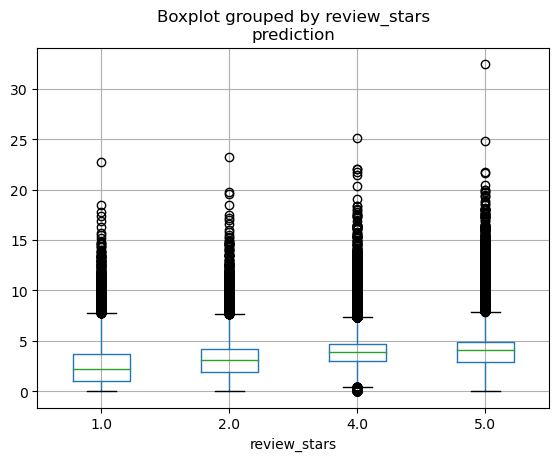

In [24]:
predictions_df.boxplot('prediction','review_stars')

In [28]:
evaluator = RegressionEvaluator(metricName='rmse', labelCol='review_stars')
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

evaluator = RegressionEvaluator(metricName='r2', labelCol='review_stars')
r2 = evaluator.evaluate(predictions)
print("r2 = " + str(r2))

23/03/05 21:29:01 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 28.5 MiB
23/03/05 21:29:03 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 28.5 MiB
23/03/05 21:29:05 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 28.5 MiB
23/03/05 21:29:23 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 28.6 MiB
23/03/05 21:29:28 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 28.6 MiB


Root-mean-square error = 1.9741840915033282


23/03/05 21:29:29 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 28.5 MiB
23/03/05 21:29:30 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 28.5 MiB
23/03/05 21:29:34 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 28.6 MiB
23/03/05 21:29:46 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 28.6 MiB


r2 = -1.0947823674273414


In [30]:
userRecs = model.recommendForAllUsers(10).limit(10)

In [31]:
userRecs.show(5)

23/03/05 21:38:32 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 28.6 MiB
23/03/05 21:42:36 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 28.6 MiB


+-----------+--------------------+
|user_id_int|     recommendations|
+-----------+--------------------+
|         15|[{32666, 14.65436...|
|         41|[{28811, 18.01359...|
|         43|[{37719, 18.52706...|
|         64|[{32666, 14.22993...|
|        112|[{33054, 8.904541...|
+-----------+--------------------+
only showing top 5 rows



In [62]:
import pyspark.sql.functions as F
from pyspark.sql.functions import regexp_replace, col
from pyspark.sql import Window

In [56]:
df_business=df_business.withColumnRenamed("stars", "Restaurant_stars")
df_business=df_business.withColumnRenamed("name", "Restaurant_name")
df_business=df_business.filter(F.col('categories').rlike('Restaurants'))
columns_to_drop = ['address','postal_code','review_count','attributes','hours']
df_business = df_business.drop(*columns_to_drop)
df_business = df_business.withColumn('categories', regexp_replace(col("categories"), "(,?\ ?Restaurants,?)", ""))
df_business = df_business.withColumn('categories', regexp_replace(col("categories"), "( ?)", ""))

In [58]:
columns_to_drop = ['cool','funny','average_stars']
df_review = df_review.drop(*columns_to_drop)

In [59]:
columns_to_drop = ['elite','useful','yelping_since','review_count','average_stars']
df_user = df_user.drop(*columns_to_drop)
df_user=df_user.withColumnRenamed("name", "user_name")

In [64]:
w = Window().orderBy('business_id')
df_business= df_business.withColumn("business_id_int", F.row_number().over(w))
w = Window().orderBy('user_id')
df_user= df_user.withColumn("user_id_int", F.row_number().over(w))

In [37]:
from pyspark.sql.functions import explode

In [66]:
# Generate top 10 restaurant recommendations for top 10 users
userRecs = model.recommendForAllUsers(10).limit(10)
userRecs_DF = (userRecs
  .select("user_id_int", explode("recommendations")
  .alias("recommendation"))
  .select("user_id_int", "recommendation.*")
)
userRecs_DF2 = userRecs_DF.join(df_user.select('user_id_int','user_name'), on='user_id_int', how ='inner').join(df_business.select('business_id_int','business_name'), on='business_id_int', how ='inner')
userRecs_df2 = userRecs_DF2.toPandas()
#print('top 10 restaurant recommendations for first 10 users')
#print(userRecs_df2.sort_values(['user_name','rating'],ascending=[True,False]).head(20))

23/03/05 22:25:58 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/05 22:25:58 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/05 22:25:59 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 28.6 MiB
23/03/05 22:26:19 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/05 22:26:19 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/05 22:26:19 WARN org.apache.spark.sql.execution.window.WindowExec: N

In [68]:
userRecs_df2.sort_values(['user_name','rating'],ascending=[True,False]).head(20)

,business_id_int,user_id_int,rating,user_name,business_name
59,25483,132,15.640345,A,Saigon Hut
58,32546,132,15.523664,A,Suburban Diner
57,44585,132,15.085613,A,World of Beer
56,42260,132,15.065444,A,Dunkin'
55,45904,132,14.711060,A,The Crazy Lobster Bar & Grill
54,41798,132,14.559182,A,Gardenville Hotel
53,32666,132,14.553707,A,Five Guys Burgers and Fries
52,30676,132,14.539232,A,Pop N Sons Diner
51,27360,132,14.275140,A,Tidwell's Fish & Shrimp House
50,35091,132,14.138081,A,Blue Collar Grill


In [69]:
# Generate top 10 user recommendations for top 10 restaurant
restaurantRecs = model.recommendForAllItems(10).limit(10)
restaurantRecs_DF = (restaurantRecs
  .select("business_id_int", explode("recommendations")
  .alias("recommendation"))
  .select("business_id_int", "recommendation.*")
)
restaurantRecs_DF2 = restaurantRecs_DF.join(df_user.select('user_id_int','user_name'), on='user_id_int', how ='inner').join(df_business.select('business_id_int','business_name'), on='business_id_int', how ='inner')
restaurantRecs_df2 = restaurantRecs_DF2.toPandas()

23/03/05 22:32:34 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/05 22:32:34 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/05 22:32:34 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 28.6 MiB
23/03/05 22:32:50 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/05 22:32:50 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/05 22:32:50 WARN org.apache.spark.sql.execution.window.WindowExec: N

In [70]:
restaurantRecs_df2.sort_values(['business_name','rating'],ascending=[True,False]).head(20)

,business_id_int,user_id_int,rating,user_name,business_name
49,140,66928,7.013889,Mark,Bocca
81,140,154389,6.726027,Seth,Bocca
64,140,105020,6.699831,Jason,Bocca
88,140,165166,6.608428,James,Bocca
78,140,150501,6.528767,Tia,Bocca
15,140,32505,6.387566,Donna,Bocca
34,140,59040,6.339371,Amber,Bocca
28,140,47791,6.317433,Stephanie,Bocca
67,140,106003,6.310277,Angela Helton,Bocca
30,140,57829,6.284889,Kyle,Bocca
